import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [1]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

#sys.path.append('/home/skong2/project/dpff4ldl')
#from utils.metrics import *
#from utils.metrics import *
#from utils.flow_functions import *
#from models.pem import *
#from models.PEM_compact import *
#from fetchData.datasetCOMBINED import *
#from trainingProtocol.trainval_COM2s_intFlow_LazyPrior_bidirection import *
#from trainingProtocol.trainval_COM2s_intFlow_sLazyPrior_bidirectionAllLayers import *
#from losses import *
#from losses_suppl import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
1.1.0


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [2]:
path_to_image = '/home/skong2/restore/dataset/pollenProject_dataset_part1'
path_to_label = '/home/skong2/restore/dataset/pollenProject_dataset_mask'

In [10]:
filename_image = '/home/skong2/restore/dataset/pollenProject_dataset_part1/abe/11.1995-1996-15-25.35.-15.14000.21000.png'
filename_label = '/home/skong2/restore/dataset/pollenProject_dataset_mask/abe/11.1995-1996-15-25.35.-15.14000.21000.bmp'
image = PIL.Image.open(filename_image)
label = PIL.Image.open(filename_label)

In [18]:
image = np.array(image)
label = np.array(label)

In [ ]:
image.shape, label.shape

In [ ]:
class PollenDet(Dataset):
    def __init__(self, path_to_image='/home/skong2/restore/dataset/pollenProject_dataset_part1',
                 path_to_label='/home/skong2/restore/dataset/pollenProject_dataset_mask',
                 size=[512, 512], 
                 set_name='train', 
                 TFNormalize=None):
        self.path_to_image = path_to_image
        self.path_to_label = path_to_label
        self.transform = transform
        self.set_name = set_name        
        self.current_set_len = 0 #len(os.listdir(self.current_set_dir))        
        self.size = size
        self.labelName = []
        self.labelIdx = []
        self.samplePath = []
        
        labelIdxCount = 0
        for subfolder in os.listdir(self.path_to_image):            
            set_path = []            
            for sampleFile in os.listdir(path.join(self.path_to_image, subfolder)): # self.sorted_dir
                if sampleFile.endswith((".png","_files")): 
                    self.samplePath += [path.join(subfolder, sampleFile[:-4])]
                    self.labelName += [subfolder]
                    self.labelIdx += [labelIdxCount] 
            labelIdxCount += 1            
        
        self.current_set_len = len(self.samplePath)
        
        self.TF2tensor = transforms.ToTensor()
        self.TF2PIL = transforms.ToPILImage()        
        self.TFNormalize = TFNormalize # transforms.Normalize((127.,127.,127.),(127.,127.,127.))        
        self.TFresize = transforms.Resize((self.size[0],self.size[1]))
        
    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):
        filename_image = path.join(self.path_to_image, subfolder, sampleFile[:-4]+'.png')
        filename_label = path.join(self.path_to_label, subfolder, sampleFile[:-4]+'.bmp')
        
        image = PIL.Image.open(filename_image)
        image = self.tmpTFresize(image)
        label = PIL.Image.open(filename_label)
        label = self.tmpTFresize(lable)
        
        if self.set_name=='train' and np.random.random(1)>0.5:
            image = image.transpose(PIL.Image.FLIP_TOP_BOTTOM)
            label = label.transpose(PIL.Image.FLIP_TOP_BOTTOM)
        if self.set_name=='train' and np.random.random(1)>0.5:
            image = image.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            label = label.transpose(PIL.Image.FLIP_LEFT_RIGHT)

        image = self.TF2tensor(image)
        label = self.TF2tensor(label)
        
        if image1.size(0)==1:
            image1 = image1.expand(3,image1.size(1),image1.size(2))
        if image2.size(0)==1:
            image2 = image2.expand(3,image2.size(1),image2.size(2))
        
        CHW = image1.size()
        if self.size[0]<=0 or self.size[1]<=0:
            self.size = [CHW[1],CHW[2]]
            self.TFResizeList = [] # transforms.Resize((24, 64))
            for i in range(len(self.downsizeFactorList)):
                self.TFResizeList += [transforms.Resize( 
                    (int(self.size[0]*self.downsizeFactorList[i]), int(self.size[1]*self.downsizeFactorList[i]))) ]
        
        elif self.set_name=='train' and self.size[0]>0 and self.size[1]>0: 
            CHW = image1.size()             
            th, tw = self.size
            th = min(th, image1.size(1))
            tw = min(tw, image1.size(2))               
            x1 = random.randint(0, CHW[2] - tw)
            y1 = random.randint(0, CHW[1] - th)
            image1 = image1[:,y1:y1+th,x1:x1+tw]
            image2 = image2[:,y1:y1+th,x1:x1+tw]
        elif self.set_name=='val' and self.size[0]>0 and self.size[1]>0: 
            CHW = image1.size() 
            th, tw = self.size
            th = min(th, image1.size(1))
            tw = min(tw, image1.size(2))
            xcenter = int(CHW[2]/2)
            ycenter = int(CHW[1]/2)            
            image1 = image1[:,ycenter-int(th/2):ycenter+int(th/2),xcenter-int(tw/2):xcenter+int(tw/2)] 
            image2 = image2[:,ycenter-int(th/2):ycenter+int(th/2),xcenter-int(tw/2):xcenter+int(tw/2)]
            
        H, W = CHW[1:]
        image1 = self.TF2PIL(image1)
        image2 = self.TF2PIL(image2)
        sampleList = []
        for curScaleIdx in range(len(self.downsizeFactorList)):
            if self.downsizeFactorList[curScaleIdx]==1:
                curImage = self.TF2tensor(image1)
                curImage = self.TFNormalize(curImage)
                sampleList += [curImage]
                curImage = self.TF2tensor(image2)
                curImage = self.TFNormalize(curImage)
                sampleList += [curImage]
            else:
                curImage = self.TFResizeList[curScaleIdx](image1)
                curImage = self.TF2tensor(curImage)
                curImage = self.TFNormalize(curImage)
                sampleList += [curImage]

                curImage = self.TFResizeList[curScaleIdx](image2)
                curImage = self.TF2tensor(curImage)
                curImage = self.TFNormalize(curImage)
                sampleList += [curImage]        
        return tuple(sampleList)        

In [2]:
## set device, which gpu to use.
device ='cpu'
supplDevice = 'cpu'
if torch.cuda.is_available(): 
    device='cuda:1'
    supplDevice='cuda:0'

################## set attributes for this project/experiment ##################
# config result folder
exp_dir = './exp' # experiment directory, used for reading the init model
project_name = 'main1004_v1_ftM1001v4_intFlow_laziness_bidir'


path_to_root = ['/home/skong2/restore/dataset/DAVIS-combo4unsup', # where to fetch data
                '/home/skong2/restore/dataset/JHMDB', 
                '/home/skong2/restore/dataset/Sintel4unsup_clean384x768/',
                '/home/skong2/restore/dataset/Sintel4unsup_final384x768/']


path_to_root = ['/home/skong2/restore/dataset/Sintel4unsup_clean384x768/',
                '/home/skong2/restore/dataset/Sintel4unsup_final384x768/']



downsizeFactorList = [1., 1/2., 1/4., 1/8., 1/16.] # [1,1/2.,1/4.,1/8.,1/16.,1/32.]
#cropSize = [384, 768] # patch size for training the model
cropSize = [256, 256] # patch size for training the model
#cropSize = [256, 512] # patch size for training the model
#cropSize = [512, 512] # patch size for training the model
#cropSize = [128, 256] # patch size for training the model
# 436x1024 --> 384x768


# 436x1024 --> 384x768


batch_size = 3
#weight4SparsityLoss = 0
dilateRate = 1
weight4FilterSmoothLoss = 1
weight4GradientDifferenceLoss = 0.001
weight4FlowVectorReconstructionLoss = 1
weight4Laziness = 0.02
weight4Bidir = 0.1
maxRangePixel = 3
borderPixel = 3

embedding_dim = 16 # dimension of the learned embedding space
kernel_size = 11
lambda_norm = 0.1
total_epoch_num = 1000 # total number of epoch in training
base_lr = 0.001 # base learning rate


torch.cuda.device_count()
torch.cuda.empty_cache()

save_dir = os.path.join(exp_dir, project_name)
print(save_dir)    
if not os.path.exists(save_dir): os.makedirs(save_dir)

log_filename = os.path.join(save_dir, 'train.log')

./exp/main1004_v1_ftM1001v4_intFlow_laziness_bidir


setup dataset
-----------

In [3]:
################## dataset ###################
TFNormalize = transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))

whole_datasets = {set_name: COMBINEDframepair(dbDirList=path_to_root,  
                                              set_name=set_name, 
                                              downsizeFactorList=downsizeFactorList,
                                              size=cropSize, # if set_name=='train' else [-1,-1],
                                              TFNormalize=TFNormalize)
                  for set_name in ['train', 'val']}



dataloaders = {set_name: DataLoader(whole_datasets[set_name], 
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=4) # num_work can be set to batch_size
               for set_name in ['train', 'val']}

dataset_sizes = {set_name: len(whole_datasets[set_name]) for set_name in ['train', 'val']}
print(dataset_sizes)
#10024+29308+1523*2

{'train': 3046, 'val': 196}


torch.Size([3, 3, 16, 16]) torch.Size([3, 3, 32, 32]) torch.Size([3, 3, 64, 64]) torch.Size([3, 3, 128, 128]) torch.Size([3, 3, 256, 256])


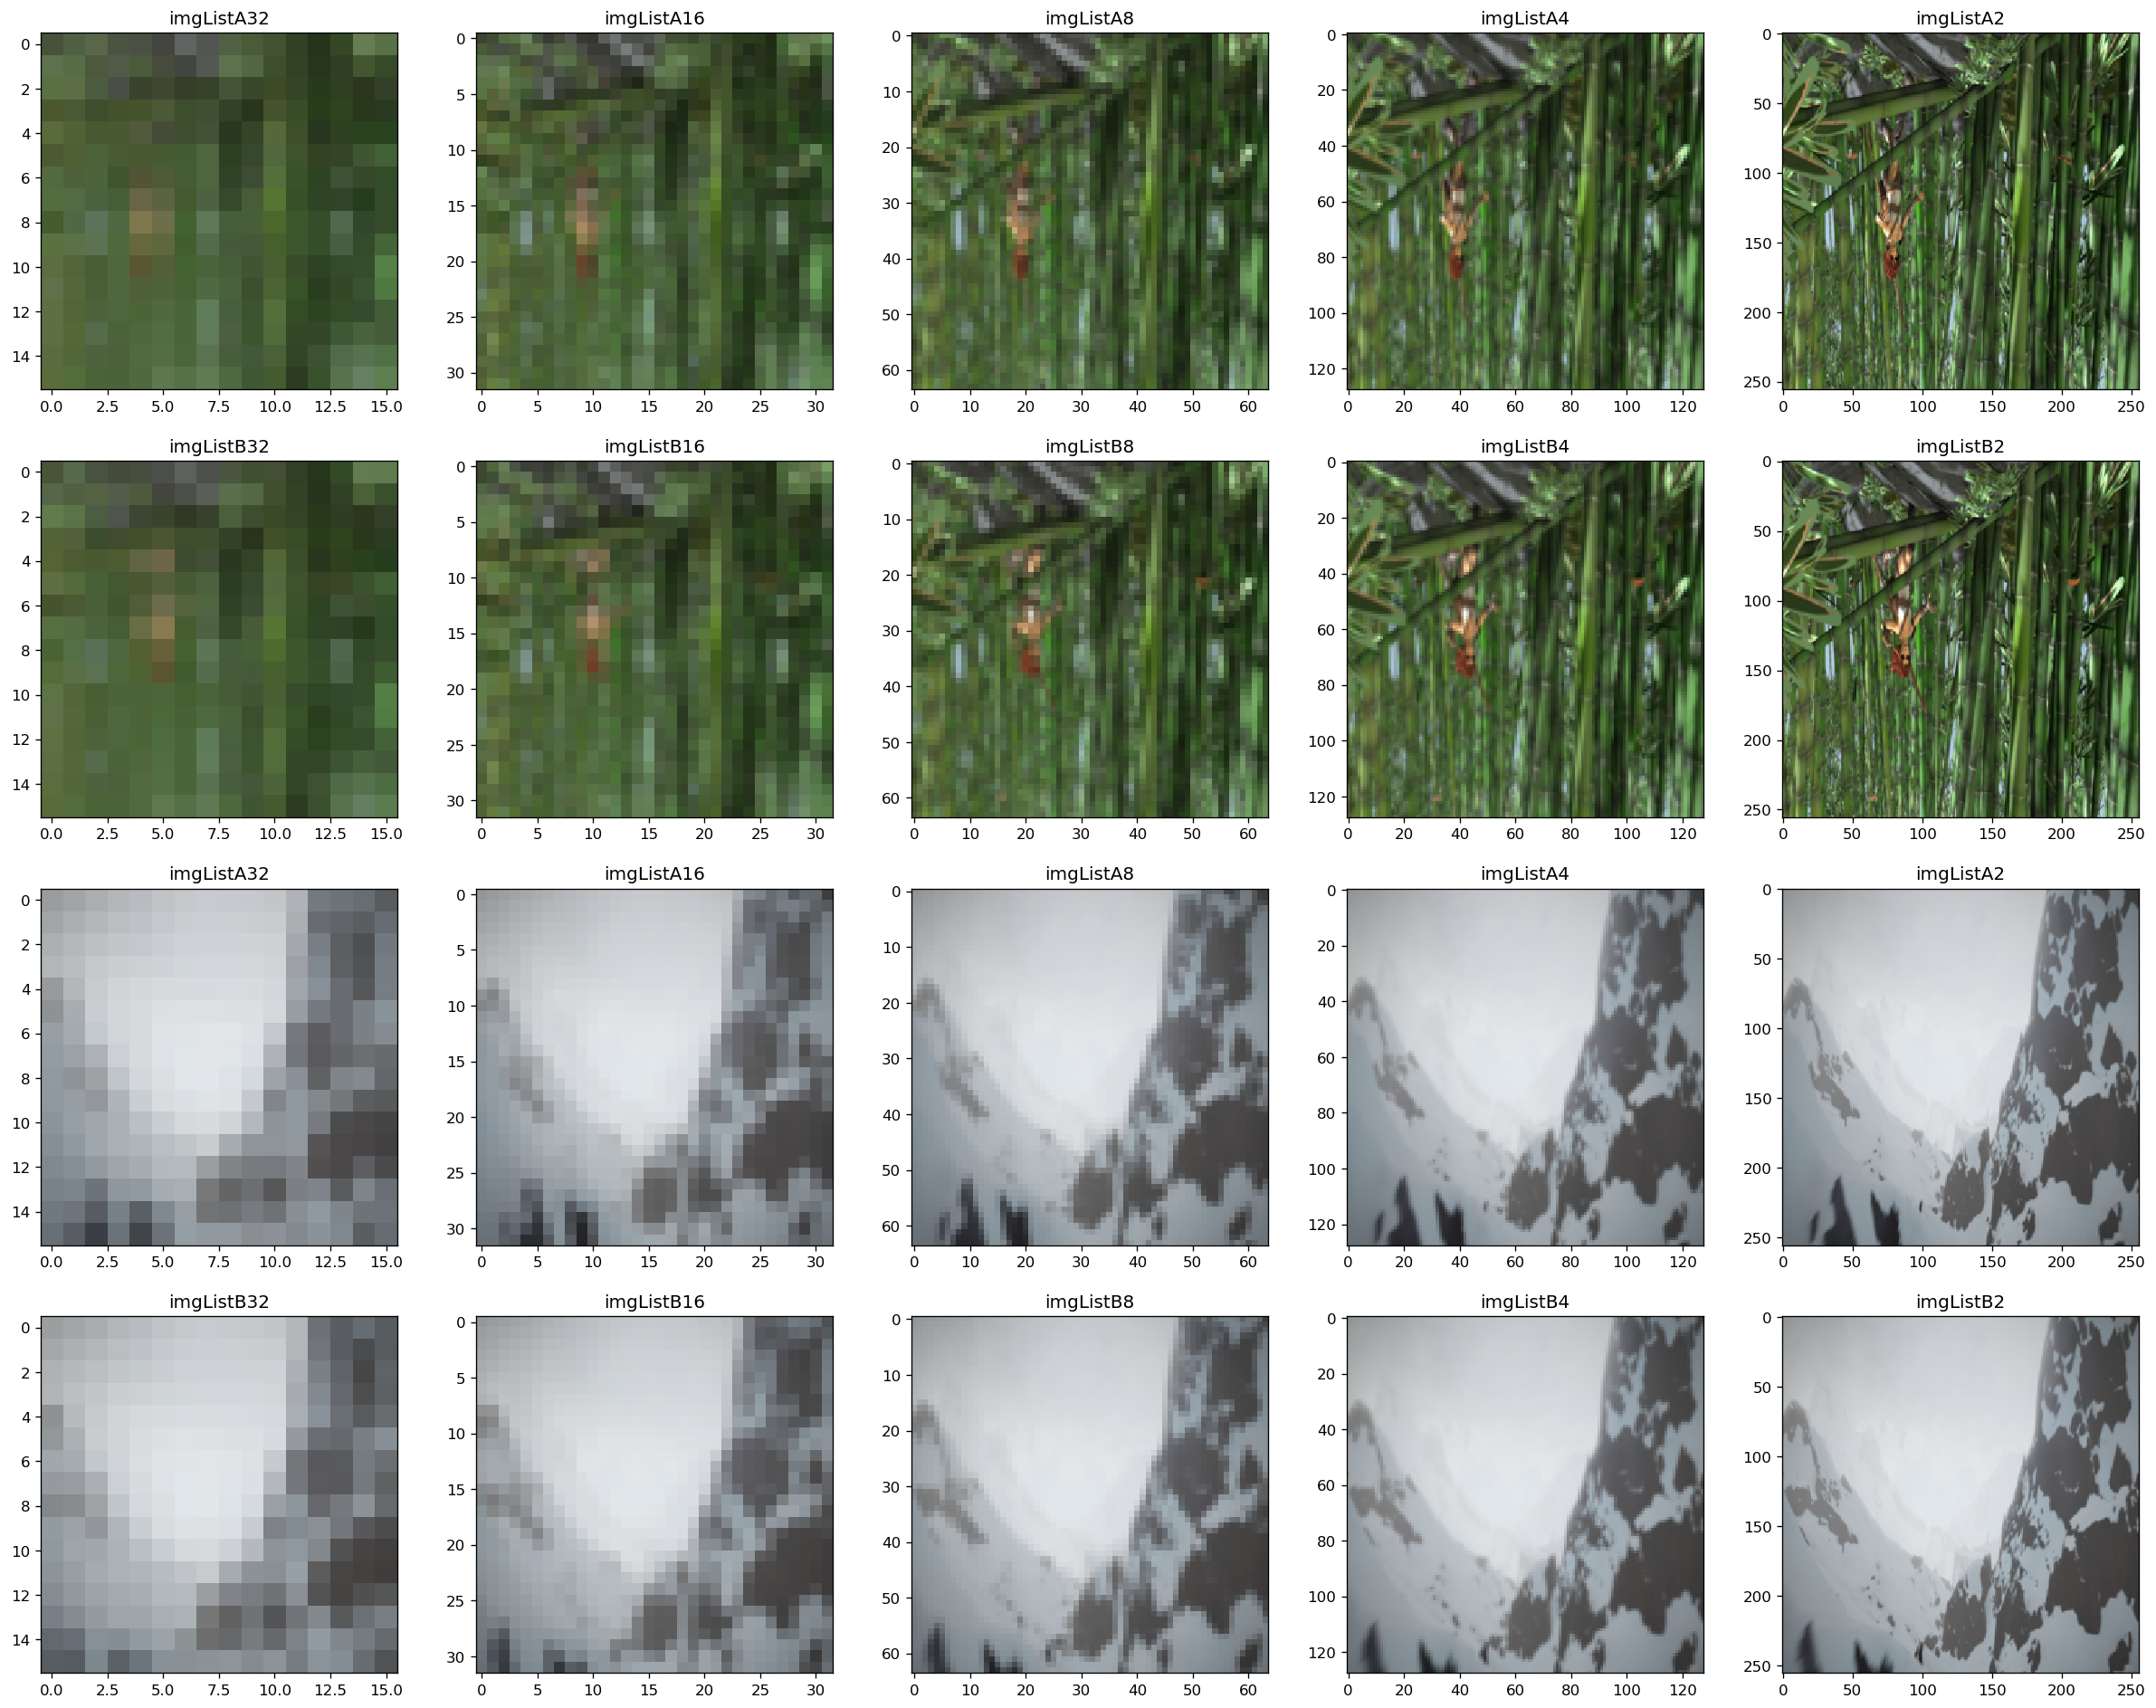

In [4]:
sample = iter(dataloaders['train']).next()
imgListA2,imgListB2, imgListA4,imgListB4, imgListA8,imgListB8 = sample[:6]
imgListA16,imgListB16,imgListA32,imgListB32 = sample[6:]
imgListA32 = imgListA32.to(device)
imgListB32 = imgListB32.to(device)
imgListA16 = imgListA16.to(device)
imgListB16 = imgListB16.to(device)
imgListA8 = imgListA8.to(device)
imgListB8 = imgListB8.to(device)
imgListA4 = imgListA4.to(device)
imgListB4 = imgListB4.to(device)
imgListA2 = imgListA2.to(device)
imgListB2 = imgListB2.to(device)

numSample2Show = 2
figWinNumHeight, figWinNumWidth = numSample2Show*2, 5
plt.figure(figsize=(figWinNumWidth*5,figWinNumHeight*5), dpi=120, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    
for sampleIndex in range(numSample2Show):
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA32[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    #plt.axis('off')
    plt.title('imgListA32')
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA16[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    #plt.axis('off')
    plt.title('imgListA16')
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA8[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    #plt.axis('off')
    plt.title('imgListA8')
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA4[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    #plt.axis('off')
    plt.title('imgListA4')
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA2[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    #plt.axis('off')
    plt.title('imgListA2')
    
    
    
    # visualize image-2
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img2 = imgListB32[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img2 = (img2+1)/2.0
    img2 = img2.clip(0,1)        
    plt.imshow(img2)
    #plt.axis('off')
    plt.title('imgListB32')
    
    # visualize image-2
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img2 = imgListB16[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img2 = (img2+1)/2.0
    img2 = img2.clip(0,1)        
    plt.imshow(img2)
    #plt.axis('off')
    plt.title('imgListB16')
    
    # visualize image-2
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img2 = imgListB8[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img2 = (img2+1)/2.0
    img2 = img2.clip(0,1)        
    plt.imshow(img2)
    #plt.axis('off')
    plt.title('imgListB8')
    
    # visualize image-2
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img2 = imgListB4[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img2 = (img2+1)/2.0
    img2 = img2.clip(0,1)        
    plt.imshow(img2)
    #plt.axis('off')
    plt.title('imgListB4')
    
    # visualize image-2
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img2 = imgListB2[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img2 = (img2+1)/2.0
    img2 = img2.clip(0,1)        
    plt.imshow(img2)
    #plt.axis('off')
    plt.title('imgListB2')
    
print(imgListA32.size(), imgListA16.size(), imgListA8.size(), imgListA4.size(), imgListA2.size())  

torch.Size([3, 3, 16, 16]) torch.Size([3, 3, 32, 32]) torch.Size([3, 3, 64, 64]) torch.Size([3, 3, 128, 128]) torch.Size([3, 3, 256, 256])


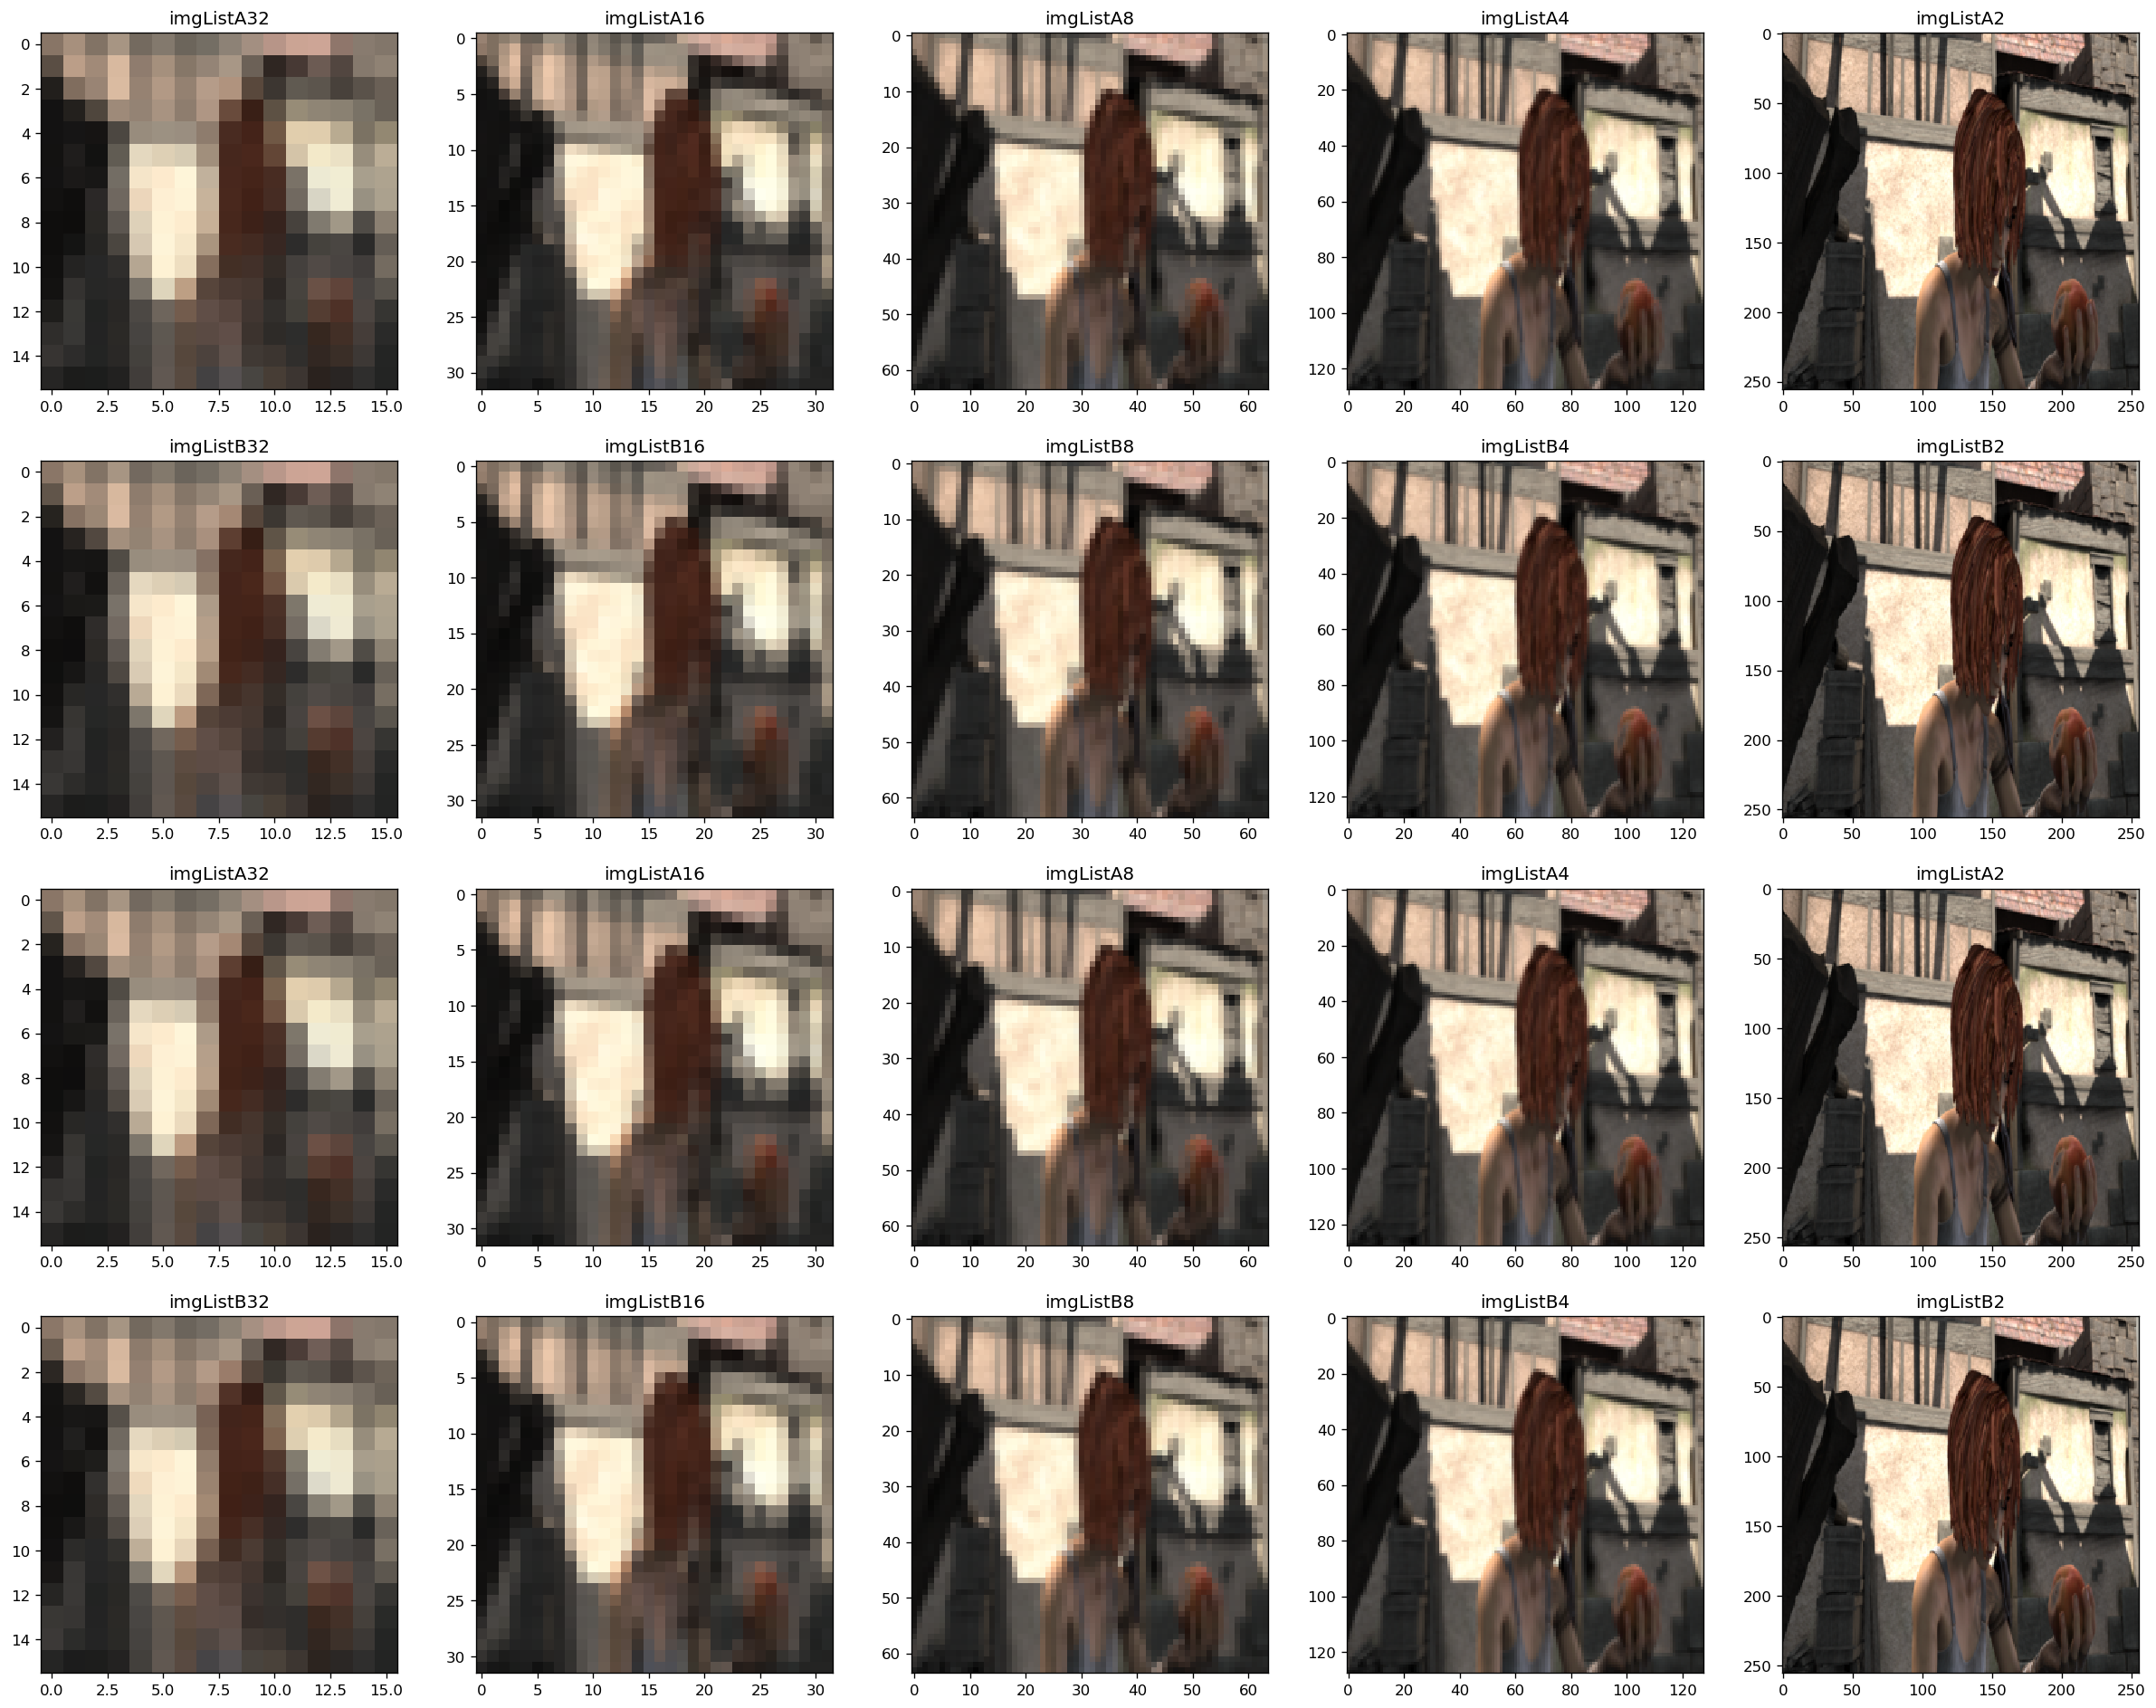

In [5]:
sample = iter(dataloaders['val']).next()
imgListA2,imgListB2, imgListA4,imgListB4, imgListA8,imgListB8 = sample[:6]
imgListA16,imgListB16,imgListA32,imgListB32 = sample[6:]
imgListA32 = imgListA32.to(device)
imgListB32 = imgListB32.to(device)
imgListA16 = imgListA16.to(device)
imgListB16 = imgListB16.to(device)
imgListA8 = imgListA8.to(device)
imgListB8 = imgListB8.to(device)
imgListA4 = imgListA4.to(device)
imgListB4 = imgListB4.to(device)
imgListA2 = imgListA2.to(device)
imgListB2 = imgListB2.to(device)

numSample2Show = 2
figWinNumHeight, figWinNumWidth = numSample2Show*2, 5
plt.figure(figsize=(figWinNumWidth*5,figWinNumHeight*5), dpi=120, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    
for sampleIndex in range(numSample2Show):
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA32[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    #plt.axis('off')
    plt.title('imgListA32')
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA16[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    #plt.axis('off')
    plt.title('imgListA16')
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA8[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    #plt.axis('off')
    plt.title('imgListA8')
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA4[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    #plt.axis('off')
    plt.title('imgListA4')
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA2[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    #plt.axis('off')
    plt.title('imgListA2')
    
    
    
    # visualize image-2
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img2 = imgListB32[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img2 = (img2+1)/2.0
    img2 = img2.clip(0,1)        
    plt.imshow(img2)
    #plt.axis('off')
    plt.title('imgListB32')
    
    # visualize image-2
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img2 = imgListB16[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img2 = (img2+1)/2.0
    img2 = img2.clip(0,1)        
    plt.imshow(img2)
    #plt.axis('off')
    plt.title('imgListB16')
    
    # visualize image-2
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img2 = imgListB8[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img2 = (img2+1)/2.0
    img2 = img2.clip(0,1)        
    plt.imshow(img2)
    #plt.axis('off')
    plt.title('imgListB8')
    
    # visualize image-2
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img2 = imgListB4[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img2 = (img2+1)/2.0
    img2 = img2.clip(0,1)        
    plt.imshow(img2)
    #plt.axis('off')
    plt.title('imgListB4')
    
    # visualize image-2
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img2 = imgListB2[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img2 = (img2+1)/2.0
    img2 = img2.clip(0,1)        
    plt.imshow(img2)
    #plt.axis('off')
    plt.title('imgListB2')
    
print(imgListA32.size(), imgListA16.size(), imgListA8.size(), imgListA4.size(), imgListA2.size())  

Define model architecture
---------

Here is the definition of the model architecture. 

In [6]:
class SiamesePixelEmbed(nn.Module):
    def __init__(self, emb_dimension=32, filterSize=11, device='cpu', pretrained=False):
        super(SiamesePixelEmbed, self).__init__()
        self.device = device
        self.emb_dimension = emb_dimension  
        #self.PEMbase = PixEmbedResTiny(emb_dimension=self.emb_dimension, pretrained=pretrained) 
        self.PEMbase = MultigridPFF_tiny(emb_dimension=self.emb_dimension) 
        
        self.rawEmbFeature1 = 0
        self.rawEmbFeature2 = 0        
        self.embFeature1_to_2 = 0
        self.embFeature1_to_2 = 0
        self.filterSize = filterSize
        self.filterSize2Channel = self.filterSize**2
                
        self.ordered_embedding = nn.Sequential(            
            nn.Conv2d(self.emb_dimension*2, self.filterSize2Channel, kernel_size=3, 
                      dilation=1, padding=1, bias=False),
            nn.BatchNorm2d(self.filterSize2Channel, momentum=0.001),     
            nn.ReLU(True),
            nn.Conv2d(self.filterSize2Channel, self.filterSize2Channel, kernel_size=3, 
                      dilation=1, padding=1, bias=False),
            nn.BatchNorm2d(self.filterSize2Channel, momentum=0.001),     
            nn.ReLU(True),
            #nn.Conv2d(self.filterSize2Channel, self.filterSize2Channel, kernel_size=3, 
            #          dilation=3, padding=3, bias=False),
            #nn.BatchNorm2d(self.filterSize2Channel, momentum=0.001),     
            #nn.ReLU(True),
            nn.Conv2d(self.filterSize2Channel, self.filterSize2Channel, kernel_size=3, 
                      padding=1, bias=False),
            nn.BatchNorm2d(self.filterSize2Channel, momentum=0.001),  
            nn.ReLU(True),          
            nn.Conv2d(self.filterSize2Channel, self.filterSize2Channel, kernel_size=3,
                      padding=1, bias=True)
        )
        
        
    def forward(self, inputs1, inputs2): 
        self.rawEmbFeature1 = self.PEMbase.forward(inputs1)
        self.rawEmbFeature2 = self.PEMbase.forward(inputs2)
        
        img1_to_img2 = torch.cat([self.rawEmbFeature1, self.rawEmbFeature2], 1)
        img2_to_img1 = torch.cat([self.rawEmbFeature2, self.rawEmbFeature1], 1)
        
        self.embFeature1_to_2 = self.ordered_embedding(img1_to_img2)        
        self.embFeature1_to_2 = F.softmax(self.embFeature1_to_2, 1)
        
        self.embFeature2_to_1 = self.ordered_embedding(img2_to_img1)
        self.embFeature2_to_1 = F.softmax(self.embFeature2_to_1, 1)
        
        return self.embFeature2_to_1, self.embFeature1_to_2   
    

Model32 = SiamesePixelEmbed(emb_dimension=embedding_dim, 
                            filterSize=kernel_size,
                            device=device, pretrained=False)
pretrainedModelPath = './exp/main0000_COMTiny32s_v1_k11fvr1sm2o3grad001_512x512/round1/epoch-143.paramOnly'
Model32.load_state_dict(torch.load(pretrainedModelPath))
Model32.to(device);
Model32.eval()   #curmodel.train()
Model32.training = False

training demo
-------------


In [7]:
################## init model ###################
initModel = SiamesePixelEmbed(emb_dimension=embedding_dim, 
                              filterSize=kernel_size,
                              device=device, pretrained=False)
#pretrainedModelPath = './exp/main0000_COMTiny32s_v1_k11fvr1sm2o3grad001_512x512/round1/epoch-143.paramOnly'
#pretrainedModelPath = './exp/main0011_COMTiny16s_v2_k11fvr1sm1o3grad0001_512x512_msLoss/j/epoch-26.paramOnly'
pretrainedModelPath = '/home/skong2/project/dpff4ldl/COMBINED/exp/main0012_COMTiny8s_v1_k11fvr1sm1o3grad0001_512x512_msLoss/j/epoch-48.paramOnly'
initModel.load_state_dict(torch.load(pretrainedModelPath))
initModel.to(device)
print('loaded pre-trained model')

loaded pre-trained model


In [ ]:
####### Training with caution! This may take very very long time, e.g., days or weeks!!

################## loss function ###################
loss_warp4reconstruction = Loss4GridSamplingWithFlowVecOffsetByFilterFlow(
    device=device,weight=weight4FlowVectorReconstructionLoss)
loss_pixelReconstruction = Loss4RobustPixelReconstruction(device=device, filterSize=kernel_size)
loss_filterSmoothness = Loss4FilterSmoothMultiScale(
    device=device, weight=weight4FilterSmoothLoss, maxRangePixel=maxRangePixel)
loss_imageGradient = Loss4ImageGradientDifference(device=device, weight=weight4GradientDifferenceLoss)

warpImgWithScale32 = WarpImageByGridSamplingWithFlowVec(device=device, scale=32)
warpImgWithScale16 = WarpImageByGridSamplingWithFlowVec(device=device, scale=16)
warpImgWithScale8 = WarpImageByGridSamplingWithFlowVec(device=device, scale=8)
warpImgWithScale4 = WarpImageByGridSamplingWithFlowVec(device=device, scale=4)
warpImgWithScale2 = WarpImageByGridSamplingWithFlowVec(device=device, scale=2)
warpImgWithScale1 = WarpImageByGridSamplingWithFlowVec(device=device, scale=1)

warpImgWithUV = WarpImageWithUV(device=device)

loss_laziness = Loss4Laziness(device=device, weight=weight4Laziness)
#loss_bidir = Loss4BidirFlowVec(device, weight=weight4Bidir)
loss_bidir = Loss4BidirFlowVecWithoutBorder(device, weight=weight4Bidir, borderPixel=borderPixel)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam([{'params': initModel.PEMbase.parameters()},
                           {'params': initModel.ordered_embedding.parameters(), 'lr': base_lr},                           
                         ], lr=base_lr)


# Decay LR by a factor of 0.2 every int(total_epoch_num/4) epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=int(total_epoch_num/4), gamma=0.2)


################## start training ###################
fn = open(log_filename,'w')
fn.write(log_filename+'\t'+device+'\n\n')
#fn.write(path.basename(__file__)+'\n\n')
fn.close()
file_to_note_bestModel = os.path.join(save_dir,'note_bestModel.log')
fn = open(file_to_note_bestModel, 'w')
fn.write('Record of best models on the way.\n')
fn.close()


model_ft = train_model(initModel, 
                       dataloaders, dataset_sizes, 
                       loss_pixelReconstruction,
                       warpImgWithScale1, warpImgWithScale2, warpImgWithScale4,
                       warpImgWithScale8, warpImgWithScale16,
                       warpImgWithUV,
                       loss_warp4reconstruction,
                       loss_filterSmoothness, 
                       loss_imageGradient,
                       loss_laziness, loss_bidir,
                       optimizer_ft, exp_lr_scheduler,
                       num_epochs=total_epoch_num, 
                       work_dir=save_dir, device=device, supplDevice=supplDevice)


Epoch 1/1000
----------
	50/1016 loss: 0.0820 Rec:0.037, FVrec:0.039, Smooth:0.005, imGrad:0.000, lazy:0.008557, bidir:0.001762


evaluation/testing demo
-----------
##### load a pretrained model

In [ ]:
################## load model ###################
path_to_save_paramOnly = os.path.join(save_dir,'bestValModel.paramOnly')
#path_to_save_paramOnly = os.path.join(save_dir,'j/epoch-23.paramOnly') # 
print(path_to_save_paramOnly)
curmodel = SiamesePixelEmbed(emb_dimension=embedding_dim, 
                             filterSize=kernel_size,
                             device=device, pretrained=False)
curmodel.load_state_dict(torch.load(path_to_save_paramOnly))
curmodel.to(device);    
#print(curmodel.state_dict)
curmodel.eval()
#curmodel.train()
curmodel.training = False
print(curmodel.training)

##### evaluating/testing on novel images, returning quantitative results

In [ ]:
################## evaluate over validation set ###################
#eval_model(curmodel, dataloaders, dataset_sizes, criterion, device=device)
loss_warp4reconstruction = Loss4GridSamplingWithFlowVecOffsetByFilterFlow(
    device=device, weight=weight4FlowVectorReconstructionLoss)
loss_pixelReconstruction = Loss4RobustPixelReconstruction(device=device, filterSize=kernel_size)
loss_pixelReconstructionX2 = Loss4RobustPixelReconstruction(device=device, filterSize=kernel_size*2)
loss_pixelReconstructionX4 = Loss4RobustPixelReconstruction(device=device, filterSize=kernel_size*4)
loss_pixelReconstructionX8 = Loss4RobustPixelReconstruction(device=device, filterSize=kernel_size*8)
loss_pixelReconstructionX16 = Loss4RobustPixelReconstruction(device=device, filterSize=kernel_size*16)
loss_pixelReconstructionX32 = Loss4RobustPixelReconstruction(device=device, filterSize=kernel_size*32)

warpImgWithScale32 = WarpImageByGridSamplingWithFlowVec(device=device, scale=32)
warpImgWithScale16 = WarpImageByGridSamplingWithFlowVec(device=device, scale=16)
warpImgWithScale8 = WarpImageByGridSamplingWithFlowVec(device=device, scale=8)
warpImgWithScale4 = WarpImageByGridSamplingWithFlowVec(device=device, scale=4)
warpImgWithScale2 = WarpImageByGridSamplingWithFlowVec(device=device, scale=2)
warpImgWithScale1 = WarpImageByGridSamplingWithFlowVec(device=device, scale=1)

visualize pixel embedding
--------

In [ ]:
set_name = 'val'
testdataloader = DataLoader(whole_datasets[set_name],  # val train
                            batch_size=3,
                            shuffle=True, #set_name=='train',  # False True
                            num_workers=1) # num_work can be set to batch_size           

In [ ]:
################## visualize some samples ###################
sample = iter(testdataloader).next()
imgListA2,imgListB2,imgListA4,imgListB4,imgListA8,imgListB8 = sample[:6]
imgListA16,imgListB16,imgListA32,imgListB32 = sample[6:]
imgListA32 = imgListA32.to(device)
imgListB32 = imgListB32.to(device)
imgListA16 = imgListA16.to(device)
imgListB16 = imgListB16.to(device)
imgListA8 = imgListA8.to(device)
imgListB8 = imgListB8.to(device)
imgListA4 = imgListA4.to(device)
imgListB4 = imgListB4.to(device)
imgListA2 = imgListA2.to(device)
imgListB2 = imgListB2.to(device)


PFFx32_2to1, PFFx32_1to2 = curmodel(imgListA32, imgListB32)
embFeat32 = curmodel.rawEmbFeature1

_ = loss_pixelReconstruction(imgListA32, imgListB32, PFFx32_1to2)
recImgB32x1_FF = loss_pixelReconstruction.reconstructImage
_ = loss_pixelReconstruction(imgListB32, imgListA32, PFFx32_2to1)
recImgA32x1_FF = loss_pixelReconstruction.reconstructImage

PFFx32_BtoA = PFFx32_2to1
PFFx32_AtoB = PFFx32_1to2
recImgA32x1 = warpImgWithScale1(imgListB32, PFFx32_BtoA)
recImgB32x1 = warpImgWithScale1(imgListA32, PFFx32_AtoB)
recImgA32x2 = warpImgWithScale2(imgListB16, PFFx32_BtoA)
recImgB32x2 = warpImgWithScale2(imgListA16, PFFx32_AtoB)
recImgA32x4 = warpImgWithScale4(imgListB8, PFFx32_BtoA)
recImgB32x4 = warpImgWithScale4(imgListA8, PFFx32_AtoB)
recImgA32x8 = warpImgWithScale8(imgListB4, PFFx32_BtoA)
recImgB32x8 = warpImgWithScale8(imgListA4, PFFx32_AtoB)
recImgA32x16 = warpImgWithScale16(imgListB2, PFFx32_BtoA)
recImgB32x16 = warpImgWithScale16(imgListA2, PFFx32_AtoB)





PFFx16_2to1, _ = curmodel(imgListA16, recImgA32x2)
embFeat16 = curmodel.rawEmbFeature1
PFFx16_BtoA = PFFx16_2to1
_ = loss_pixelReconstruction(recImgA32x2, imgListA16, PFFx16_BtoA)
recImgA16x1_FF = loss_pixelReconstruction.reconstructImage
recImgA16x1 = warpImgWithScale1(recImgA32x2, PFFx16_BtoA)
recImgA16x2 = warpImgWithScale2(recImgA32x4, PFFx16_BtoA)
recImgA16x4 = warpImgWithScale4(recImgA32x8, PFFx16_BtoA)
recImgA16x8 = warpImgWithScale8(recImgA32x16, PFFx16_BtoA)


PFFx8_2to1, _ = curmodel(imgListA8, recImgA16x2)
embFeat8 = curmodel.rawEmbFeature1
PFFx8_BtoA = PFFx8_2to1
_ = loss_pixelReconstruction(recImgA16x2, imgListA8, PFFx8_BtoA)
recImgA8x1_FF = loss_pixelReconstruction.reconstructImage
recImgA8x1 = warpImgWithScale1(recImgA16x2, PFFx8_BtoA)
recImgA8x2 = warpImgWithScale2(recImgA16x4, PFFx8_BtoA)
recImgA8x4 = warpImgWithScale4(recImgA16x8, PFFx8_BtoA)



PFFx4_2to1, _ = curmodel(imgListA4, recImgA8x2)
embFeat4 = curmodel.rawEmbFeature1
PFFx4_BtoA = PFFx4_2to1
_ = loss_pixelReconstruction(recImgA8x2, imgListA4, PFFx4_BtoA)
recImgA4x1_FF = loss_pixelReconstruction.reconstructImage
recImgA4x1 = warpImgWithScale1(recImgA8x2, PFFx4_BtoA)
recImgA4x2 = warpImgWithScale2(recImgA8x4, PFFx4_BtoA)




PFFx2_2to1, _ = curmodel(imgListA2, recImgA4x2)
embFeat2 = curmodel.rawEmbFeature1
PFFx2_BtoA = PFFx2_2to1
_ = loss_pixelReconstruction(recImgA4x2, imgListA2, PFFx2_BtoA)
recImgA2x1_FF = loss_pixelReconstruction.reconstructImage
recImgA2x1 = warpImgWithScale1(recImgA4x2, PFFx2_BtoA)


In [ ]:
embFeat = curmodel.rawEmbFeature1
NCHW = embFeat.size()

emb2showMat = embFeat.view(NCHW[0],NCHW[1],-1)
print(emb2showMat.shape)

torch.manual_seed(7)
randProj = torch.randn(3,embedding_dim).to(device)
emb2showMat = torch.matmul(randProj, emb2showMat)
emb2showMat = emb2showMat.view(NCHW[0], 3, NCHW[2], NCHW[3])
emb2showMat -= emb2showMat.min()
emb2showMat /= emb2showMat.max()
print(emb2showMat.shape)

#gridShow = torchvision.utils.make_grid(emb2showMat, padding=3)
#gridShow = gridShow.detach().cpu().permute((1,2,0))
#plt.imshow(gridShow)
emb2showMat = emb2showMat.detach().cpu().permute((0,2,3,1))



figWinNumHeight, figWinNumWidth = 1, 3
plt.figure(figsize=(figWinNumWidth*4,figWinNumHeight*4), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1   

for idx in range(figWinNumHeight*figWinNumWidth):
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    plt.imshow(emb2showMat[idx])

In [ ]:
NCHW = embFeat32.size()
emb2showMat = embFeat32.view(NCHW[0],NCHW[1],-1)
print(emb2showMat.shape)

figWinNumHeight, figWinNumWidth = 1, 3
plt.figure(figsize=(figWinNumWidth*4,figWinNumHeight*4), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1   

for idx in range(figWinNumHeight*figWinNumWidth):
    X = emb2showMat[idx].squeeze()
    X = torch.t(X)
    X_mean = torch.mean(X,0)
    X = X - X_mean.expand_as(X)
    U,S,V = torch.svd(torch.t(X))
    C = torch.mm(X, U[:,:3])
    C = C.view(NCHW[2],NCHW[3],3).detach().cpu()
    C = C-C.min()
    C = C/C.max()    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    plt.imshow(C)

In [ ]:
NCHW = embFeat16.size()
emb2showMat = embFeat16.view(NCHW[0],NCHW[1],-1)
print(emb2showMat.shape)

figWinNumHeight, figWinNumWidth = 1, 3
plt.figure(figsize=(figWinNumWidth*4,figWinNumHeight*4), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1   

for idx in range(figWinNumHeight*figWinNumWidth):
    X = emb2showMat[idx].squeeze()
    X = torch.t(X)
    X_mean = torch.mean(X,0)
    X = X - X_mean.expand_as(X)
    U,S,V = torch.svd(torch.t(X))
    C = torch.mm(X, U[:,:3])
    C = C.view(NCHW[2],NCHW[3],3).detach().cpu()
    C = C-C.min()
    C = C/C.max()    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    plt.imshow(C)

In [ ]:
NCHW = embFeat8.size()
emb2showMat = embFeat8.view(NCHW[0],NCHW[1],-1)
print(emb2showMat.shape)

figWinNumHeight, figWinNumWidth = 1, 3
plt.figure(figsize=(figWinNumWidth*4,figWinNumHeight*4), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1   

for idx in range(figWinNumHeight*figWinNumWidth):
    X = emb2showMat[idx].squeeze()
    X = torch.t(X)
    X_mean = torch.mean(X,0)
    X = X - X_mean.expand_as(X)
    U,S,V = torch.svd(torch.t(X))
    C = torch.mm(X, U[:,:3])
    C = C.view(NCHW[2],NCHW[3],3).detach().cpu()
    C = C-C.min()
    C = C/C.max()    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    plt.imshow(C)

In [ ]:
NCHW = embFeat4.size()
emb2showMat = embFeat4.view(NCHW[0],NCHW[1],-1)
print(emb2showMat.shape)

figWinNumHeight, figWinNumWidth = 1, 3
plt.figure(figsize=(figWinNumWidth*4,figWinNumHeight*4), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1   

for idx in range(figWinNumHeight*figWinNumWidth):
    X = emb2showMat[idx].squeeze()
    X = torch.t(X)
    X_mean = torch.mean(X,0)
    X = X - X_mean.expand_as(X)
    U,S,V = torch.svd(torch.t(X))
    C = torch.mm(X, U[:,:3])
    C = C.view(NCHW[2],NCHW[3],3).detach().cpu()
    C = C-C.min()
    C = C/C.max()    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    plt.imshow(C)

In [ ]:
NCHW = embFeat2.size()
emb2showMat = embFeat2.view(NCHW[0],NCHW[1],-1)
print(emb2showMat.shape)

figWinNumHeight, figWinNumWidth = 1, 3
plt.figure(figsize=(figWinNumWidth*4,figWinNumHeight*4), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1   

for idx in range(figWinNumHeight*figWinNumWidth):
    X = emb2showMat[idx].squeeze()
    X = torch.t(X)
    X_mean = torch.mean(X,0)
    X = X - X_mean.expand_as(X)
    G = torch.mm(torch.t(X),X)
    U,S,V = torch.svd(G)
    C = torch.mm(X, U[:,:3])
    C = C.view(NCHW[2],NCHW[3],3).detach().cpu()
    C = C-C.min()
    C = C/C.max()    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    plt.imshow(C)

In [ ]:
figWinNumHeight, figWinNumWidth = 1, 3
plt.figure(figsize=(24,7), dpi=96, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1  

embFeat = curmodel.rawEmbFeature1

#torch.manual_seed(777)
random.seed(1)
channelSize = embFeat.size(1)
for i in range(3):
    frameIdx = random.choice(range(channelSize-3))
    out4show = embFeat[:,frameIdx:frameIdx+3,:,:]
    gridShow = torchvision.utils.make_grid(out4show, padding=5 )
    
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    whole_datasets['val'].imshow(gridShow)
    plt.axis('off')

In [ ]:
objDemoShowFlow = DemoShowFlow() # height=int(Y.max()), width=int(Y.max())
#objDemoShowFlow.height = Y.max()
#objDemoShowFlow.width = Y.max()

plt.figure()
plt.imshow(objDemoShowFlow.FlowColorChart)
plt.show()
#misc.imsave(os.path.join(save_dir, 'colorchar.png'.format(idx)), objDemoShowFlow.FlowColorChart*255, format='png')

In [ ]:
imgNumtoShow = 3
colorList = ['k', 'r', 'b', 'm', 'c']

figWinNumHeight, figWinNumWidth = 5*imgNumtoShow, 5
plt.figure(figsize=(figWinNumWidth*5,figWinNumHeight*5), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

for sampleIndex in range(imgNumtoShow):
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA32[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('imgA 1/32', color=colorList[sampleIndex])

    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListB32[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('imgB 1/32 (input&real)', color=colorList[sampleIndex])

    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListB32[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('imgB 1/32', color=colorList[sampleIndex])

    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    flowVis = PFFx32_BtoA[sampleIndex].cpu()
    UV = objDemoShowFlow.filterFlow2UV(flowVis).detach().numpy()
    UV = UV/np.ceil(kernel_size/2)
    #UV = UV/UV.max()
    flowVisShow = objDemoShowFlow.computeColor(UV[0], UV[1])/255.    
    plt.imshow(flowVisShow)
    plt.axis('off')
    plt.title('flow 1/32: imgB->imgA', color=colorList[sampleIndex])      
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = recImgA32x1[sampleIndex].detach().cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('recImgA flowVec 1/32', color=colorList[sampleIndex])
    
    
    
    
    
    
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA16[sampleIndex].cpu().detach().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('imgA 1/16', color=colorList[sampleIndex])

    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = recImgA32x2[sampleIndex].cpu().detach().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('recImgA 1/32x2 (input)', color=colorList[sampleIndex])

    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListB16[sampleIndex].cpu().detach().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('imgB 1/16', color=colorList[sampleIndex])

    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    flowVis = PFFx16_BtoA[sampleIndex].cpu()
    UV = objDemoShowFlow.filterFlow2UV(flowVis).detach().numpy()
    UV = UV/np.ceil(kernel_size/2)
    #UV = UV/UV.max()
    flowVisShow = objDemoShowFlow.computeColor(UV[0], UV[1])/255.    
    plt.imshow(flowVisShow)
    plt.axis('off')
    plt.title('flow 1/16: imgB->imgA', color=colorList[sampleIndex])      
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = recImgA16x1[sampleIndex].detach().cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('recImgA flowVec 1/16', color=colorList[sampleIndex])

    
    
    
    
    
    
    
    
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA8[sampleIndex].cpu().detach().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('imgA 1/8', color=colorList[sampleIndex])

    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = recImgA16x2[sampleIndex].cpu().detach().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('recImgA 1/16x2 (input)', color=colorList[sampleIndex])

    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListB8[sampleIndex].cpu().detach().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('imgB 1/8', color=colorList[sampleIndex])

    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    flowVis = PFFx8_BtoA[sampleIndex].cpu()
    UV = objDemoShowFlow.filterFlow2UV(flowVis).detach().numpy()
    UV = UV/np.ceil(kernel_size/2)
    #UV = UV/UV.max()
    flowVisShow = objDemoShowFlow.computeColor(UV[0], UV[1])/255.    
    plt.imshow(flowVisShow)
    plt.axis('off')
    plt.title('flow 1/8: imgB->imgA', color=colorList[sampleIndex])        
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = recImgA8x1[sampleIndex].detach().cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('recImgA flowVec 1/8', color=colorList[sampleIndex])
    
    
    
    
    
    
    
    
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA4[sampleIndex].cpu().detach().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('imgA 1/4', color=colorList[sampleIndex])

    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = recImgA8x2[sampleIndex].cpu().detach().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('recImgA 1/8x2 (input)', color=colorList[sampleIndex])

    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListB4[sampleIndex].cpu().detach().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('imgB 1/4', color=colorList[sampleIndex])

    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    flowVis = PFFx4_BtoA[sampleIndex].cpu()
    UV = objDemoShowFlow.filterFlow2UV(flowVis).detach().numpy()
    UV = UV/np.ceil(kernel_size/2)
    #UV = UV/UV.max()
    flowVisShow = objDemoShowFlow.computeColor(UV[0], UV[1])/255.    
    plt.imshow(flowVisShow)
    plt.axis('off')
    plt.title('flow 1/4: imgB->imgA', color=colorList[sampleIndex])        
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = recImgA4x1[sampleIndex].detach().cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('recImgA flowVec 1/4', color=colorList[sampleIndex])
    
    
    
    
    
    
    
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA2[sampleIndex].cpu().detach().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('imgA 1/2', color=colorList[sampleIndex])

    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = recImgA4x2[sampleIndex].cpu().detach().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('recImgA 1/4x2 (input)', color=colorList[sampleIndex])

    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListB2[sampleIndex].cpu().detach().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('imgB 1/2', color=colorList[sampleIndex])

    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    flowVis = PFFx2_BtoA[sampleIndex].cpu()
    UV = objDemoShowFlow.filterFlow2UV(flowVis).detach().numpy()
    UV = UV/np.ceil(kernel_size/2)
    #UV = UV/UV.max()
    flowVisShow = objDemoShowFlow.computeColor(UV[0], UV[1])/255.    
    plt.imshow(flowVisShow)
    plt.axis('off')
    plt.title('flow 1/2: imgB->imgA', color=colorList[sampleIndex])        
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = recImgA2x1[sampleIndex].detach().cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('recImgA flowVec 1/2', color=colorList[sampleIndex])

In [ ]:
imgNumtoShow = 3
colorList = ['k', 'r', 'b', 'm', 'c']

figWinNumHeight, figWinNumWidth = 4*imgNumtoShow, 4
plt.figure(figsize=(figWinNumWidth*5,figWinNumHeight*3), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

for sampleIndex in range(imgNumtoShow):
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA32[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('imgA 1/32', color=colorList[sampleIndex])

    # visualize image-2
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img2 = imgListB32[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img2 = (img2+1)/2.0
    img2 = img2.clip(0,1)        
    plt.imshow(img2)
    plt.axis('off')
    plt.title('imgB 1/32', color=colorList[sampleIndex])    
    
    # visualize a predicted flowmap for reconstructing image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    recimg1 = recImgA32x1[sampleIndex].detach().cpu().numpy().squeeze().transpose((1,2,0))    
    recimg1 = (recimg1+1)/2.0
    recimg1 = recimg1.clip(0,1)        
    plt.imshow(recimg1)
    plt.axis('off')
    plt.title('recImgA 1/32', color=colorList[sampleIndex])    
    
    img1 = imgListA32[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))   
    recimg1 = recImgA32x1[sampleIndex].detach().cpu().numpy().squeeze().transpose((1,2,0))    
    errMap = np.mean(np.abs(img1-recimg1),2)
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    plt.imshow(errMap)
    plt.axis('off')
    plt.title('errMap', color=colorList[sampleIndex])
    plt.colorbar()
    
    
    
    
    
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA16[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('imgA 1/16', color=colorList[sampleIndex])

    # visualize image-2
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img2 = imgListB16[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img2 = (img2+1)/2.0
    img2 = img2.clip(0,1)        
    plt.imshow(img2)
    plt.axis('off')
    plt.title('imgB 1/16', color=colorList[sampleIndex])    
    
    # visualize a predicted flowmap for reconstructing image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    recimg1 = recImgA16x1[sampleIndex].detach().cpu().numpy().squeeze().transpose((1,2,0))    
    recimg1 = (recimg1+1)/2.0
    recimg1 = recimg1.clip(0,1)        
    plt.imshow(recimg1)
    plt.axis('off')
    plt.title('recImgA 1/16', color=colorList[sampleIndex])    
    
    img1 = imgListA16[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))   
    recimg1 = recImgA16x1[sampleIndex].detach().cpu().numpy().squeeze().transpose((1,2,0))    
    errMap = np.mean(np.abs(img1-recimg1),2)
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    plt.imshow(errMap)
    plt.axis('off')
    plt.title('errMap', color=colorList[sampleIndex])
    plt.colorbar()
    
    
    
    
    
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA8[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('imgA 1/8', color=colorList[sampleIndex])

    # visualize image-2
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img2 = imgListB8[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img2 = (img2+1)/2.0
    img2 = img2.clip(0,1)        
    plt.imshow(img2)
    plt.axis('off')
    plt.title('imgB 1/8', color=colorList[sampleIndex])    
    
    # visualize a predicted flowmap for reconstructing image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    recimg1 = recImgA8x1[sampleIndex].detach().cpu().numpy().squeeze().transpose((1,2,0))    
    recimg1 = (recimg1+1)/2.0
    recimg1 = recimg1.clip(0,1)        
    plt.imshow(recimg1)
    plt.axis('off')
    plt.title('recImgA 1/8', color=colorList[sampleIndex])    
    
    img1 = imgListA8[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))   
    recimg1 = recImgA8x1[sampleIndex].detach().cpu().numpy().squeeze().transpose((1,2,0))    
    errMap = np.mean(np.abs(img1-recimg1),2)
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    plt.imshow(errMap)
    plt.axis('off')
    plt.title('errMap', color=colorList[sampleIndex])
    plt.colorbar()
    
    
    
    
    
    
    # visualize image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img1 = imgListA4[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img1 = (img1+1)/2.0
    img1 = img1.clip(0,1)        
    plt.imshow(img1)
    plt.axis('off')
    plt.title('imgA 1/4', color=colorList[sampleIndex])

    # visualize image-2
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    img2 = imgListB4[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))    
    img2 = (img2+1)/2.0
    img2 = img2.clip(0,1)        
    plt.imshow(img2)
    plt.axis('off')
    plt.title('imgB 1/4', color=colorList[sampleIndex])    
    
    # visualize a predicted flowmap for reconstructing image-1
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    recimg1 = recImgA4x1[sampleIndex].detach().cpu().numpy().squeeze().transpose((1,2,0))    
    recimg1 = (recimg1+1)/2.0
    recimg1 = recimg1.clip(0,1)        
    plt.imshow(recimg1)
    plt.axis('off')
    plt.title('recImgA 1/4', color=colorList[sampleIndex])    
    
    img1 = imgListA4[sampleIndex].cpu().numpy().squeeze().transpose((1,2,0))   
    recimg1 = recImgA4x1[sampleIndex].detach().cpu().numpy().squeeze().transpose((1,2,0))    
    errMap = np.mean(np.abs(img1-recimg1),2)
    plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
    subwinCount += 1
    plt.imshow(errMap)
    plt.axis('off')
    plt.title('errMap', color=colorList[sampleIndex])
    plt.colorbar()



Leaving Blank
-----